# SastaTicket Datathon Flight Price Prediction and Analysis

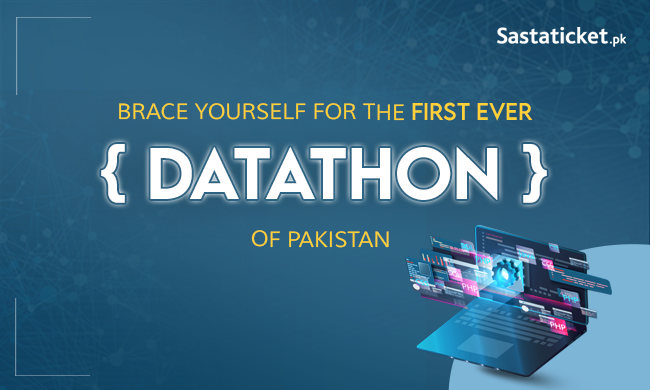

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
import warnings
import pickle
import category_encoders as ce
import math
warnings.filterwarnings('ignore')

In [2]:
# Set maximum number of columns
pd.set_option('display.max_columns', None)

In [3]:
# Set Number of Samples from the file to be trained ( Its for Normal Computer If you have a good high level server then full data can be trained)
n_samples = 21776590
#n_samples = 10000

# Importing dataset¶
1.Since data is in form of csv file we have to use pandas read_csv to load the data.

2.After loading it is important to check null values in a column or a row

3.If it is present then following can be done,

Filling NaN values with mean, median and mode using fillna() method
If Less missing values, we can drop it as well

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
# loading x_test.csv file
df_X_test = pd.read_csv("X_test.csv")

In [6]:
#information about the data
df_X_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532489 entries, 0 to 4532488
Data columns (total 10 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f1      object 
 1   f2      object 
 2   f3      object 
 3   f4      object 
 4   f5      object 
 5   f6      object 
 6   f7      bool   
 7   f8      float64
 8   f9      int64  
 9   f10     object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 315.5+ MB


In [7]:
#describe about the data
df_X_test.describe()

f8            f9
count  4.532489e+06  4.532489e+06
mean   2.201668e+01  9.891111e-01
std    7.738736e+00  5.539422e-01
min    0.000000e+00  0.000000e+00
25%    2.000000e+01  1.000000e+00
50%    2.000000e+01  1.000000e+00
75%    2.000000e+01  1.000000e+00
max    4.000000e+01  2.000000e+00

In [8]:
#checking total number of rows and columns
print(df_X_test.shape) 
#Initial structure of the data
df_X_test.head()

(4532489, 10)


f1 f2 f3                         f4  \
0  2021-09-01 08:30:19.320999+00:00  x  y  2021-09-08 11:00:00+00:00   
1  2021-09-01 08:30:19.320999+00:00  x  y  2021-09-08 14:00:00+00:00   
2  2021-09-01 08:30:19.320999+00:00  x  y  2021-09-08 05:00:00+00:00   
3  2021-09-01 08:30:20.396761+00:00  x  y  2021-09-08 05:30:00+00:00   
4  2021-09-01 08:30:20.396761+00:00  x  y  2021-09-08 05:30:00+00:00   

                          f5     f6    f7    f8  f9   f10  
0  2021-09-08 12:55:00+00:00   beta  True  40.0   0  b-69  
1  2021-09-08 15:55:00+00:00   beta  True  40.0   0   b-9  
2  2021-09-08 06:55:00+00:00   beta  True  20.0   0   b-1  
3  2021-09-08 07:30:00+00:00  gamma  True  20.0   2   c-2  
4  2021-09-08 07:30:00+00:00  gamma  True  20.0   1   c-2

In [9]:
#finding the null values
df_X_test.isnull().sum()

f1     0
f2     0
f3     0
f4     0
f5     0
f6     0
f7     0
f8     0
f9     0
f10    0
dtype: int64

In [24]:
# loading y_train.csv file
df_y_train = pd.read_csv("y_train.csv")

In [25]:
#Initial structure of the data
df_y_train.head()

Unnamed: 0   target
0           0   7400.0
1           1   8650.0
2           2   9150.0
3           3  10400.0
4           4   8697.0

In [26]:
#Remove unwanted column
df_y_train.drop(['Unnamed: 0'],axis=1, inplace=True)

In [27]:
#information about the data
df_y_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21776590 entries, 0 to 21776589
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   target  float64
dtypes: float64(1)
memory usage: 166.1 MB


In [14]:
#describe about the data
df_y_train.describe()

target
count  2.177659e+07
mean   1.013705e+04
std    3.447472e+03
min    0.000000e+00
25%    7.796000e+03
50%    9.380000e+03
75%    1.124500e+04
max    3.500000e+04

In [15]:
#checking total number of rows and columns
print(df_y_train.shape) 

(21776590, 1)


In [16]:
#Initial structure of the data
df_y_train.head()

target
0   7400.0
1   8650.0
2   9150.0
3  10400.0
4   8697.0

In [17]:
#finding the null values
df_y_train.isnull().sum()

target    0
dtype: int64

In [16]:
#Read 
df_X_train = pd.read_csv("X_train.csv")

In [19]:
#Initial structure of the data
df_X_train.head(10)

Unnamed: 0                                f1 f2 f3  \
0           0  2020-12-31 09:46:17.463002+00:00  x  y   
1           1  2020-12-31 09:46:17.463002+00:00  x  y   
2           2  2020-12-31 09:46:17.463002+00:00  x  y   
3           3  2020-12-31 09:46:17.463002+00:00  x  y   
4           4  2020-12-31 09:46:18.191119+00:00  x  y   
5           5  2020-12-31 09:46:18.191119+00:00  x  y   
6           6  2020-12-31 09:46:18.191119+00:00  x  y   
7           7  2020-12-31 09:46:18.191119+00:00  x  y   
8           8  2020-12-31 09:46:19.878719+00:00  x  y   
9           9  2020-12-31 09:46:19.878719+00:00  x  y   

                          f4                         f5     f6     f7    f8  \
0  2021-01-10 05:00:00+00:00  2021-01-10 07:00:00+00:00  gamma   True   0.0   
1  2021-01-10 05:00:00+00:00  2021-01-10 07:00:00+00:00  gamma   True  32.0   
2  2021-01-10 11:00:00+00:00  2021-01-10 13:00:00+00:00  gamma   True  32.0   
3  2021-01-10 11:00:00+00:00  2021-01-10 13:00:00+00:00  gamma   True  32.0   
4  2021-01-25 11:00:00+00:00  2021-01-25 12:55:00+00:00   beta  False  20.0   
5  2021-01-25 05:00:00+00:00  2021-01-25 06:55:00+00:00   beta  False  20.0   
6  2021-01-25 14:00:00+00:00  2021-01-25 15:55:00+00:00   beta  False  20.0   
7  2021-01-25 16:00:00+00:00  2021-01-25 17:55:00+00:00   beta  False  20.0   
8  2021-01-25 11:00:00+00:00  2021-01-25 13:00:00+00:00  gamma   True  32.0   
9  2021-01-25 11:00:00+00:00  2021-01-25 13:00:00+00:00  gamma   True  32.0   

   f9   f10  
0   0   c-2  
1   1   c-2  
2   1   c-4  
3   2   c-4  
4   0  b-69  
5   0   b-1  
6   0   b-9  
7   0  b-19  
8   2   c-4  
9   1   c-4

In [20]:
#information about the data
df_X_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21776590 entries, 0 to 21776589
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   f1          object 
 2   f2          object 
 3   f3          object 
 4   f4          object 
 5   f5          object 
 6   f6          object 
 7   f7          bool   
 8   f8          float64
 9   f9          int64  
 10  f10         object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 1.6+ GB


In [21]:
#describe about the data
df_X_train.describe()

Unnamed: 0            f8            f9
count  2.177659e+07  2.177659e+07  2.177659e+07
mean   1.088829e+07  2.258956e+01  9.491727e-01
std    6.286360e+06  8.885366e+00  6.077294e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    5.444147e+06  2.000000e+01  1.000000e+00
50%    1.088829e+07  2.000000e+01  1.000000e+00
75%    1.633244e+07  3.200000e+01  1.000000e+00
max    2.177659e+07  4.500000e+01  2.000000e+00

In [22]:
#finding the null values
df_X_train.isnull().sum()

Unnamed: 0    0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
dtype: int64

In [23]:
# Checking row of x and y train data set
df_X_train.shape[0] == df_y_train.shape[0]

True

In [8]:
# Logical names to the columns 
test_columns = ["Ticket Purchase Date Time","Origin","Destination","Departure Date Time",
                    "Arrival Date Time","Airline","Refundable Ticket","Baggage Weight","Baggage Pieces",
                    "Flight Number"]
def assignColumns(df):   

     # Dropif we have extra unused column
    if 'Unnamed: 0' in df:
        df = df.drop(['Unnamed: 0'],axis = 1)
    
    # Giving logical names to the column for better understanding
    df.columns = test_columns
    
    return df;


# Data Cleaning & Pre Processing



In [9]:
# defining date time formatter as per data 
dateTimeFormatter = '%Y-%m-%d %H:%M:%S.%f'


In [11]:

def prepareData(df):
    pd.options.mode.chained_assignment = None 
    
    df = assignColumns(df);
    
    # The datatypes of "Ticket Purchase Date Time","Departure Date Time" and "Arrival Date Time" is object.So,firstly we convert it into date and time for proper predicion.
    # dt.day method will extract only day of that date
    # dt.month method will extract only month of that date
    # dt.year method will extract only year of that date
    # dt.hour method will extract only hour of that date
    # dt.minute method will extract only minute of that date    
    
    df[[test_columns[0],test_columns[3],test_columns[4]]] = df[[test_columns[0],test_columns[3],test_columns[4]]].apply(pd.to_datetime, format=dateTimeFormatter)
   
    #seperating 
    df["Ticket Purchase Day"] = pd.to_datetime(df[test_columns[0]],format=dateTimeFormatter).dt.day
    df["Ticket Purchase Month"] = pd.to_datetime(df[test_columns[0]],format=dateTimeFormatter).dt.month
    df["Ticket Purchase Year"] = pd.to_datetime(df[test_columns[0]],format=dateTimeFormatter).dt.year
    df["Ticket Purchase Hour"] = pd.to_datetime(df[test_columns[0]],format=dateTimeFormatter).dt.hour
    df["Ticket Purchase Minute"] = pd.to_datetime(df[test_columns[0]],format=dateTimeFormatter).dt.minute

    df["Departure Day"] = pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter).dt.day
    df["Departure Month"] = pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter).dt.month
    df["Departure Year"] = pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter).dt.year
    df["Departure Hour"] = pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter).dt.hour
    df["Departure Minute"] = pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter).dt.minute
    
    df["Arrival Day"] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter).dt.day
    df["Arrival Month"] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter).dt.month
    df["Arrival Year"] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter).dt.year
    df["Arrival Hour"] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter).dt.hour
    df["Arrival Minute"] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter).dt.minute

    # Calculating flight duration  by DepartHour and Arrival hours and minutes
    #DepartHours = df["Departure Hour"] + (df["Departure Minute"]/60)
    #ArrivalHours = df["Arrival Hour"] + (df["Arrival Minute"]/60)
    
    try:
        df['Duration Mins'] = pd.to_datetime(df[test_columns[4]],format=dateTimeFormatter) - pd.to_datetime(df[test_columns[3]],format=dateTimeFormatter)
    except:
        print('Except')
        print(df[test_columns[4]])
        print(df[test_columns[3]])
        return df;
    

    df['Duration Mins'] = (df['Duration Mins']/np.timedelta64(1,'m')).round(0).astype(int)
    

    #df['Duration Hours'] = df[test_columns[4]] - df[test_columns[3]]
    #df['Duration Hours'] = df['Duration Hours']/np.timedelta64(1,'h')
    

    #df['Duration Seconds'] = df[test_columns[4]] - df[test_columns[3]]
    #df['Duration Seconds'] = df['Duration Seconds']/np.timedelta64(1,'s')
 
    
    
    df["Flight Number"] = df["Flight Number"].str.extract('(\d+)').astype(int)

    
    # Adding flight duration column in dataframe
    #df["FlightDuration"] = ArrivalHours - DepartHours
    
    # From "Ticket Purchase Date Time","Departure Date Time" and "Arrival Date Time" features, we extract day,month, year, hour and minute and stored in new columns and drop these columns¶
    df.drop([test_columns[0],test_columns[1],test_columns[2],test_columns[3], test_columns[4]], axis = 1, inplace = True)
    
    # As "Flight Number" is Nominal Categorical data we will perform OneHotEncoding
    #FlightNumber = pd.get_dummies(df[test_columns[9]], drop_first= True) 
    
    # As Airline is Nominal Categorical data we will perform OneHotEncoding
    Airline = pd.get_dummies(df[test_columns[5]],drop_first=False)
    
    # Perform label encoding on "Refundable Ticket", "Airline" and  "Baggage Pieces" data
    df.replace({True: 1, False: 0}, inplace = True)
    df.replace({0: 0, 15:1, 20:2, 32:3, 35:4, 40:5, 45:6}, inplace = True)

    # Concatenate OneHotEncoding data
    #df = pd.concat([df, FlightNumber], axis = 1)
    df = pd.concat([df, Airline], axis = 1)
    
    # Drop "Flight Number" as new OneHotEncoding column is already added 
    #df.drop([test_columns[9]], axis = 1, inplace = True)
    # dropping "Baggage Weight" column since it has baised data
    df.drop([test_columns[5],test_columns[6]], axis = 1, inplace = True)

    # return clean dataframe
    return df


In [12]:
df_X_test = prepareData(df_X_test)

In [13]:
df_X_test.head()

Baggage Weight  Baggage Pieces  Flight Number  Ticket Purchase Day  \
0             5.0               0             69                    1   
1             5.0               0              9                    1   
2             2.0               0              1                    1   
3             2.0               2              2                    1   
4             2.0               1              2                    1   

   Ticket Purchase Month  Ticket Purchase Year  Ticket Purchase Hour  \
0                      9                  2021                     8   
1                      9                  2021                     8   
2                      9                  2021                     8   
3                      9                  2021                     8   
4                      9                  2021                     8   

   Ticket Purchase Minute  Departure Day  Departure Month  Departure Year  \
0                      30              8                9            2021   
1                      30              8                9            2021   
2                      30              8                9            2021   
3                      30              8                9            2021   
4                      30              8                9            2021   

   Departure Hour  Departure Minute  Arrival Day  Arrival Month  Arrival Year  \
0              11                 0            8              9          2021   
1              14                 0            8              9          2021   
2               5                 0            8              9          2021   
3               5                30            8              9          2021   
4               5                30            8              9          2021   

   Arrival Hour  Arrival Minute  Duration Mins  alpha  beta  gamma  omega  
0            12              55            115      0     1      0      0  
1             1              55            115      0     1      0      0  
2             6              55            115      0     1      0      0  
3             7              30            120      0     0      1      0  
4             7              30            120      0     0      1      0

In [17]:
df_X_train = prepareData(df_X_train)

In [14]:
df_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532489 entries, 0 to 4532488
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Baggage Weight          float64
 1   Baggage Pieces          int64  
 2   Flight Number           int32  
 3   Ticket Purchase Day     int64  
 4   Ticket Purchase Month   int64  
 5   Ticket Purchase Year    int64  
 6   Ticket Purchase Hour    int64  
 7   Ticket Purchase Minute  int64  
 8   Departure Day           int64  
 9   Departure Month         int64  
 10  Departure Year          int64  
 11  Departure Hour          int64  
 12  Departure Minute        int64  
 13  Arrival Day             int64  
 14  Arrival Month           int64  
 15  Arrival Year            int64  
 16  Arrival Hour            int64  
 17  Arrival Minute          int64  
 18  Duration Mins           int32  
 19  alpha                   uint8  
 20  beta                    uint8  
 21  gamma                   uint8  

In [18]:
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21776590 entries, 0 to 21776589
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Baggage Weight          float64
 1   Baggage Pieces          int64  
 2   Flight Number           int32  
 3   Ticket Purchase Day     int64  
 4   Ticket Purchase Month   int64  
 5   Ticket Purchase Year    int64  
 6   Ticket Purchase Hour    int64  
 7   Ticket Purchase Minute  int64  
 8   Departure Day           int64  
 9   Departure Month         int64  
 10  Departure Year          int64  
 11  Departure Hour          int64  
 12  Departure Minute        int64  
 13  Arrival Day             int64  
 14  Arrival Month           int64  
 15  Arrival Year            int64  
 16  Arrival Hour            int64  
 17  Arrival Minute          int64  
 18  Duration Mins           int32  
 19  alpha                   uint8  
 20  beta                    uint8  
 21  gamma                   uint8

In [19]:
col = df_X_train.columns

In [20]:
reduce_mem_usage(df_X_train)

Memory usage of dataframe is 3073.63 MB
Memory usage after optimization is: 685.34 MB
Decreased by 77.7%


Baggage Weight  Baggage Pieces  Flight Number  Ticket Purchase Day  \
0                    0.0               0              2                   31   
1                    3.0               1              2                   31   
2                    3.0               1              4                   31   
3                    3.0               2              4                   31   
4                    2.0               0             69                   31   
...                  ...             ...            ...                  ...   
21776585             2.0               1              7                   31   
21776586             1.0               1              9                   31   
21776587             2.0               1              1                   31   
21776588             2.0               1              3                   31   
21776589             2.0               1              5                   31   

          Ticket Purchase Month  Ticket Purchase Year  Ticket Purchase Hour  \
0                            12                  2020                     9   
1                            12                  2020                     9   
2                            12                  2020                     9   
3                            12                  2020                     9   
4                            12                  2020                     9   
...                         ...                   ...                   ...   
21776585                      8                  2021                    23   
21776586                      8                  2021                    23   
21776587                      8                  2021                    23   
21776588                      8                  2021                    23   
21776589                      8                  2021                    23   

          Ticket Purchase Minute  Departure Day  Departure Month  \
0                             46             10                1   
1                             46             10                1   
2                             46             10                1   
3                             46             10                1   
4                             46             25                1   
...                          ...            ...              ...   
21776585                      29              3                9   
21776586                      29              3                9   
21776587                      29              3                9   
21776588                      29              3                9   
21776589                      29              3                9   

          Departure Year  Departure Hour  Departure Minute  Arrival Day  \
0                   2021               5                 0           10   
1                   2021               5                 0           10   
2                   2021              11                 0           10   
3                   2021              11                 0           10   
4                   2021              11                 0           25   
...                  ...             ...               ...          ...   
21776585            2021              10                 0            3   
21776586            2021              13                 5            3   
21776587            2021               4                 5            3   
21776588            2021              10                 4            3   
21776589            2021              17                 5            3   

          Arrival Month  Arrival Year  Arrival Hour  Arrival Minute  \
0                     1          2021             7               0   
1                     1          2021             7               0   
2                     1          2021            13               0   
3                     1          2021            13               0   
4                     1    

In [21]:
reduce_mem_usage(df_X_test)

Memory usage of dataframe is 639.73 MB
Memory usage after optimization is: 138.32 MB
Decreased by 78.4%


Baggage Weight  Baggage Pieces  Flight Number  Ticket Purchase Day  \
0                   5.0               0             69                    1   
1                   5.0               0              9                    1   
2                   2.0               0              1                    1   
3                   2.0               2              2                    1   
4                   2.0               1              2                    1   
...                 ...             ...            ...                  ...   
4532484             1.0               1             23                   30   
4532485             2.0               1             23                   30   
4532486             2.0               1              5                   30   
4532487             2.0               1              3                   30   
4532488             2.0               1              1                   30   

         Ticket Purchase Month  Ticket Purchase Year  Ticket Purchase Hour  \
0                            9                  2021                     8   
1                            9                  2021                     8   
2                            9                  2021                     8   
3                            9                  2021                     8   
4                            9                  2021                     8   
...                        ...                   ...                   ...   
4532484                      9                  2021                     0   
4532485                      9                  2021                     0   
4532486                      9                  2021                     0   
4532487                      9                  2021                     0   
4532488                      9                  2021                     0   

         Ticket Purchase Minute  Departure Day  Departure Month  \
0                            30              8                9   
1                            30              8                9   
2                            30              8                9   
3                            30              8                9   
4                            30              8                9   
...                         ...            ...              ...   
4532484                      12             30                9   
4532485                      12             30                9   
4532486                      12             30                9   
4532487                      12             30                9   
4532488                      12             30                9   

         Departure Year  Departure Hour  Departure Minute  Arrival Day  \
0                  2021              11                 0            8   
1                  2021              14                 0            8   
2                  2021               5                 0            8   
3                  2021               5                30            8   
4                  2021               5                30            8   
...                 ...             ...               ...          ...   
4532484            2021              16                 0           30   
4532485            2021              16                 0           30   
4532486            2021              17                 5           30   
4532487            2021              10                50           30   
4532488            2021               4                 6           30   

         Arrival Month  Arrival Year  Arrival Hour  Arrival Minute  \
0                    9          2021            12              55   
1                    9          2021             1              55   
2                    9          2021             6              55   
3                    9          2021             7              30   
4                    9          2021             7              30   
...      

In [28]:
reduce_mem_usage(df_y_train)

Memory usage of dataframe is 166.14 MB
Memory usage after optimization is: 41.54 MB
Decreased by 75.0%


target
0          7400.0
1          8648.0
2          9152.0
3         10400.0
4          8696.0
...           ...
21776585   8384.0
21776586   9048.0
21776587   6156.0
21776588   6156.0
21776589   6604.0

[21776590 rows x 1 columns]

In [146]:
df_X_train.head()

Airline  Refundable Ticket  Baggage Weight  Baggage Pieces Flight Number  \
0   gamma                  1             0.0               0           c-2   
1   gamma                  1             3.0               1           c-2   
2   gamma                  1             3.0               1           c-4   
3   gamma                  1             3.0               2           c-4   
4    beta                  0             2.0               0          b-69   

   Ticket Purchase Day  Ticket Purchase Month  Ticket Purchase Year  \
0                   31                     12                  2020   
1                   31                     12                  2020   
2                   31                     12                  2020   
3                   31                     12                  2020   
4                   31                     12                  2020   

   Ticket Purchase Hour  Ticket Purchase_Minute  Departure Day  \
0                     9                      46             10   
1                     9                      46             10   
2                     9                      46             10   
3                     9                      46             10   
4                     9                      46             25   

   Departure Month  Departure Year  Departure Hour  Departure Minute  \
0                1            2021               5                 0   
1                1            2021               5                 0   
2                1            2021              11                 0   
3                1            2021              11                 0   
4                1            2021              11                 0   

   Arrival Day  Arrival Month  Arrival Year  Arrival Hour  Arrival Minute  \
0           10              1          2021             7               0   
1           10              1          2021             7               0   
2           10              1          2021            13               0   
3           10              1          2021            13               0   
4           25              1          2021            12              55   

   FlightDuration  
0        2.000000  
1        2.000000  
2        2.000000  
3        2.000000  
4        1.916667

# Count of flights with different Airlines

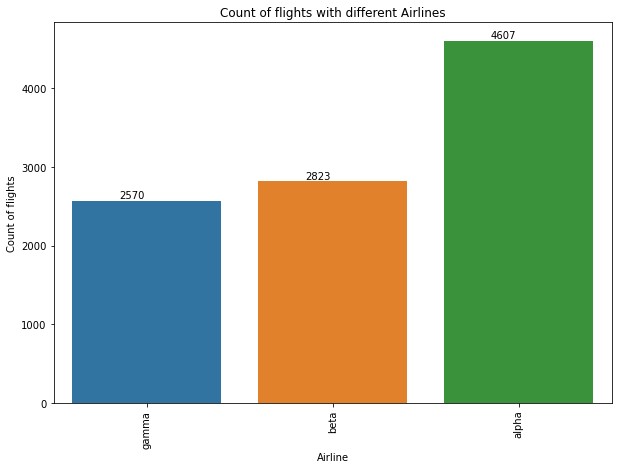

In [147]:
plt.figure(figsize = (10, 7))
plt.title('Count of flights with different Airlines')
ax=sns.countplot(x = 'Airline', data = df_X_train)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

# Group by Airline

In [148]:
df_X_train.groupby('Airline').sum()


Refundable Ticket  Baggage Weight  Baggage Pieces  \
Airline                                                      
alpha                 4607          4646.0            2323   
beta                     0          8745.0               0   
gamma                 2570          5856.0            2619   

         Ticket Purchase Day  Ticket Purchase Month  Ticket Purchase Year  \
Airline                                                                     
alpha                 142817                  55284               9306140   
beta                   87513                  33876               5702460   
gamma                  79670                  30840               5191400   

         Ticket Purchase Hour  Ticket Purchase_Minute  Departure Day  \
Airline                                                                
alpha                   54122                  129804          39551   
beta                    33121                   79832          25366   
gamma                   30072                   72214          25312   

         Departure Month  Departure Year  Departure Hour  Departure Minute  \
Airline                                                                      
alpha               5526         9310688           52488              3676   
beta                3346         5705255           31582                 0   
gamma               2846         5193970           21538                 0   

         Arrival Day  Arrival Month  Arrival Year  Arrival Hour  \
Airline                                                           
alpha          39551           5526       9310688         40478   
beta           25366           3346       5705255         23387   
gamma          25312           2846       5193970         26604   

         Arrival Minute  FlightDuration  
Airline                                  
alpha             54010     9741.166667  
beta             155265     5410.750000  
gamma              4366     5138.766667

# Airline vs Price

In [149]:
df_X_train['Price'] = df_y_train['target']

In [150]:
fig = px.histogram(df_X_train, 
                   x='Price', 
                   marginal='box', 
                   color='Airline', 
                   color_discrete_sequence=['green', 'grey','red','orange','blue','blueviolet', 'brown', 'burlywood', 'chocolate', 'darkblue','olive','pink'], 
                   title='Airline vs Price')
fig.update_layout(bargap=0.1)
fig.show()

# Flight Number vs Price

<AxesSubplot:xlabel='Flight Number', ylabel='Price'>

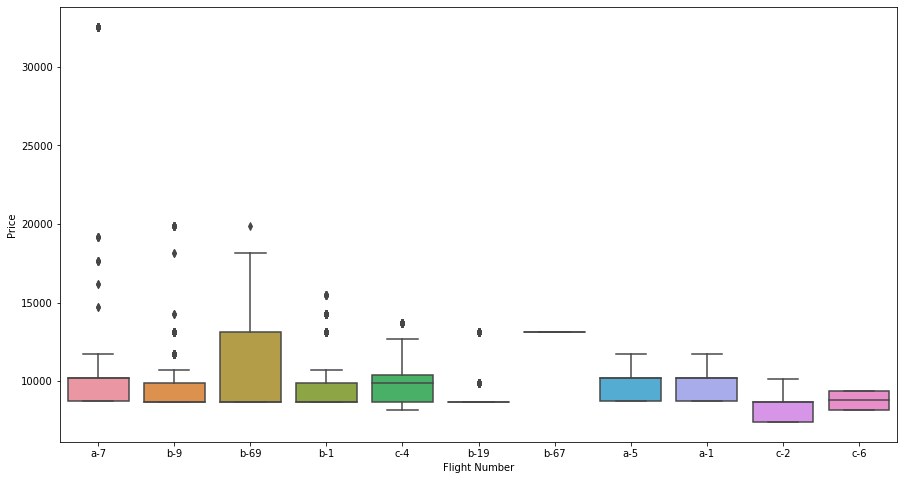

In [151]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Flight Number',y='Price',data=df_X_train.sort_values('Price',ascending=False))

# Airline, Flight Number and Price visualization with 3D view¶


In [152]:
fig = px.scatter_3d(df_X_train, x='Airline', y='Flight Number', z='Price')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

# Finding corelation 

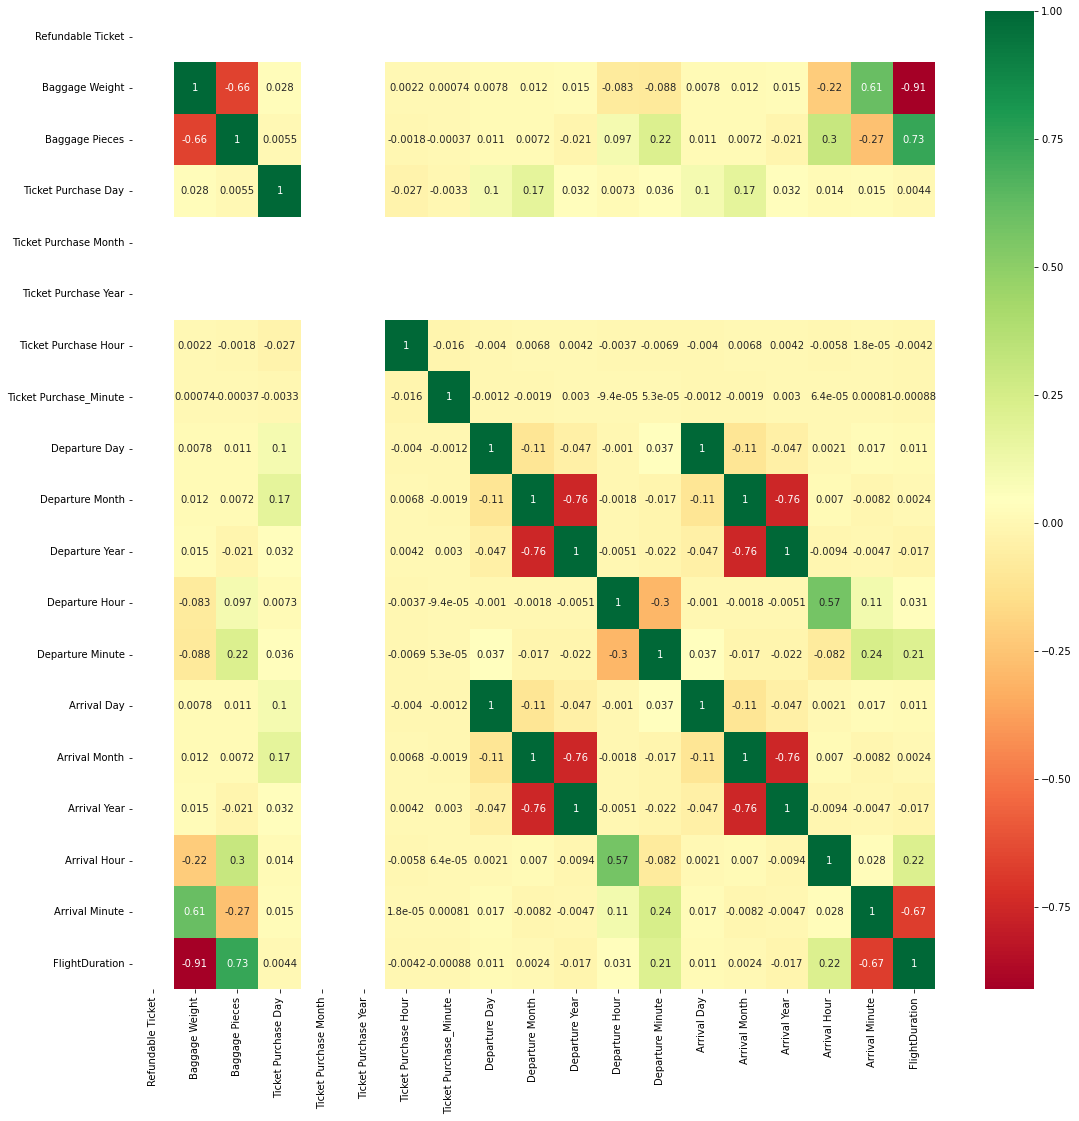

In [153]:
plt.figure(figsize=(18,18))
sns.heatmap(df_X_test.corr(),annot=True,cmap='RdYlGn')
plt.show()

# FlightDuration vs Price visualization with scatter plot¶


In [154]:
fig = px.scatter(df_X_train, 
                 x='FlightDuration', 
                 y='Price', 
                 #color='Source', 
                 opacity=0.8, 
                 hover_data=['Airline'], 
                 title='Flight Duration vs. Price')
fig.update_traces(marker_size=5)
fig.show()

# Frequency of Flight based on Arrival and Departure  day and month

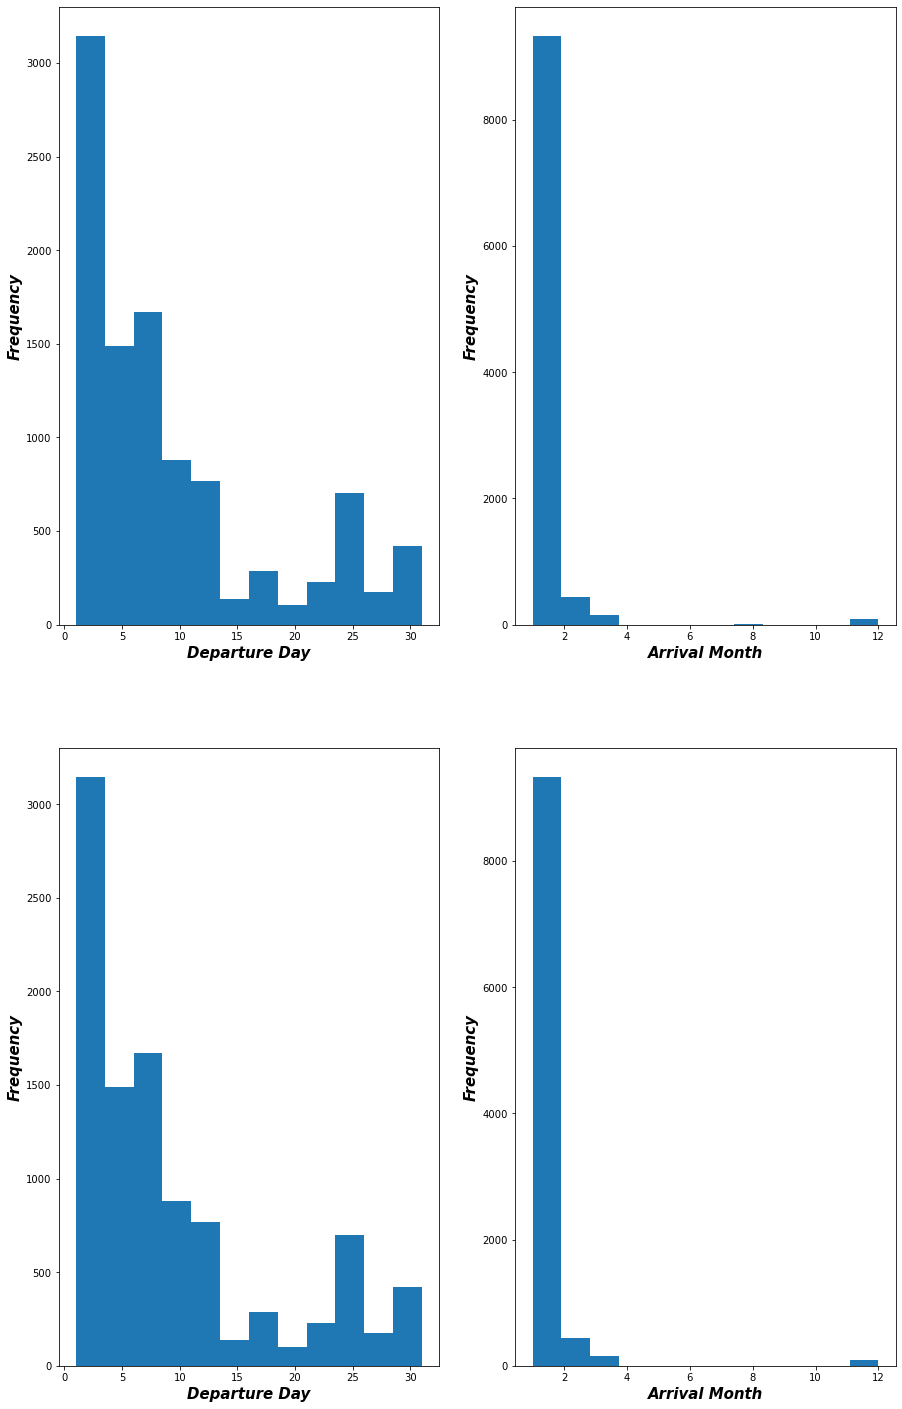

In [155]:
fig = plt.figure(figsize=(15,25))
plt.subplot(221) 
plt.hist(df_X_train['Arrival Day'] , bins=12)
plt.xlabel('Departure Day',fontsize = 15 , fontweight='bold' , fontstyle='italic')
plt.ylabel('Frequency',fontsize = 15 , fontweight='bold' , fontstyle='italic')

plt.subplot(222) 
plt.hist(df_X_train['Arrival Month'] , bins=12)
plt.xlabel('Arrival Month',fontsize = 15 , fontweight='bold' , fontstyle='italic')
plt.ylabel('Frequency',fontsize = 15 , fontweight='bold' , fontstyle='italic')

plt.subplot(223) 
plt.hist(df_X_train['Departure Day'] , bins=12)
plt.xlabel('Departure Day',fontsize = 15 , fontweight='bold' , fontstyle='italic')
plt.ylabel('Frequency',fontsize = 15 , fontweight='bold' , fontstyle='italic')


plt.subplot(224) 
plt.hist(df_X_train['Departure Month'] , bins=12)
plt.xlabel('Arrival Month',fontsize = 15 , fontweight='bold' , fontstyle='italic')
plt.ylabel('Frequency',fontsize = 15 , fontweight='bold' , fontstyle='italic')


plt.show()

Our observations:

- Most flights are in the month of Janruary
- Most flights are in 1st week of the all months.

# Day Expand and Cost visualization with Animation¶


In [156]:
px.scatter(data_frame=df_X_train,
                x= 'Price',
                y='Departure Day',
                size='Departure Month',
                color='FlightDuration',
                title= 'Day Expand and Cost',
                labels= {'Price': 'Cost','Departure_Day': 'Day Expand'},
                log_x= True,
                range_y= [0,400],
                hover_name= 'Airline',
                animation_frame='Price',
                height= 400,
                size_max=40)

# Feature Selection / Training & Testing Model with Parameter Hypertuning


In [157]:
df_X_train.drop(['Price'],axis=1, inplace=True)
df_X_train.drop(['FlightDuration'],axis=1, inplace=True)
df_X_test.drop(['FlightDuration'],axis=1, inplace=True)

In [161]:
col = df_X_train.columns

In [162]:
#encoding
#encoder = ce.OrdinalEncoder(cols=col)

In [163]:
# Encoding train & test data samples
#x_train = encoder.fit_transform(df_X_train)
#x_test = encoder.transform(df_X_test)

In [164]:
# We have use a vast number of Models, but if the data is heavy then its recommend to use the models depending on your system.
algorithms = {

	'RandomForestRegressor': {
		'model': RandomForestRegressor(),
		'param': {
			'n_estimators': [300, 500, 700, 1000, 2100],
			'max_depth': [3, 5, 7, 9, 11, 13, 15],
			'max_features': ["auto", "sqrt", "log2"],
			'min_samples_split': [2, 4, 6, 8]
		}
	},
	'GradientBoostingRegressor': {
		'model': GradientBoostingRegressor(),
		'param': {
			'learning_rate': [0.5, 0.8, 0.1, 0.20, 0.25, 0.30],
			'n_estimators': [300, 500, 700, 1000, 2100],
			'criterion': ['friedman_mse', 'mse']
		}
	},
	'KNeighborsRegressor': {
		'model': KNeighborsRegressor(),
		'param': {
			'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
		}
	},
	'DecisionTreeRegressor': {
		'model': DecisionTreeRegressor(),
		'param': {
			"splitter": ["best", "random"],
			"max_depth": [1, 3, 5, 7, 9, 11, 12],
			"min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
			"min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
			"max_features": ["auto", "log2", "sqrt", None],
			"max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90]
		}

	},
	'ExtraTreeRegressor': {
		'model': ExtraTreeRegressor(),
		'param': {
			'max_depth': [2, 3, 4, 5, 7, 8, 9, 10],
			'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
			'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 10],
			'max_features': [0.95],
			'min_impurity_decrease': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10]
		}
	},
	'XGBRegressor': {
		'model': XGBRegressor(),
		'param': {
			'max_depth': [3, 18, 1],
			'gamma': [1, 9],
			'reg_alpha': [40, 180, 1],
			'reg_lambda': [0, 1],
			'colsample_bytree': [0.5, 1],
			'min_child_weight': [0, 10, 1],
			'n_estimators': [300, 500, 700, 1000, 2100]
		}
	}



}

In [166]:
score = []
for name, mp in algorithms.items() :
    rs = RandomizedSearchCV(estimator = mp['model'], param_distributions = mp['param'], cv = 2, n_jobs=-1, verbose=2)
    rs.fit(x_train, df_y_train)
    prediction = rs.predict(x_test)
    score.append({
        'ModelName': name,
        'Model': rs,
        'Score' : rs.best_score_,
        'Params' : rs.best_params_,
        'Predictions': prediction
    }) 

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [167]:
ModelScore = pd.DataFrame (score, columns= ['ModelName','Model', 'Score','Params','Predictions'])

In [168]:
ModelScore.head()

ModelName  \
0      RandomForestRegressor   
1  GradientBoostingRegressor   
2        KNeighborsRegressor   
3      DecisionTreeRegressor   
4         ExtraTreeRegressor   

                                               Model     Score  \
0  RandomizedSearchCV(cv=2, estimator=RandomFores...  0.913874   
1  RandomizedSearchCV(cv=2, estimator=GradientBoo...  0.884047   
2  RandomizedSearchCV(cv=2, estimator=KNeighborsR...  0.514667   
3  RandomizedSearchCV(cv=2, estimator=DecisionTre...  0.252736   
4  RandomizedSearchCV(cv=2, estimator=ExtraTreeRe...  0.896640   

                                              Params  \
0  {'n_estimators': 500, 'min_samples_split': 8, ...   
1  {'n_estimators': 300, 'learning_rate': 0.1, 'c...   
2                                 {'n_neighbors': 3}   
3  {'splitter': 'best', 'min_weight_fraction_leaf...   
4  {'min_samples_split': 3, 'min_samples_leaf': 6...   

                                         Predictions  
0  [11750.820855540205, 11856.27449745371, 8714.1...  
1  [13237.769083794425, 12831.421090214224, 8690....  
2  [[10163.666666666666], [10163.666666666666], [...  
3  [11985.79477250726, 11985.79477250726, 8682.69...  
4  [13097.0, 13097.0, 8697.0, 8697.0, 8697.0, 869...

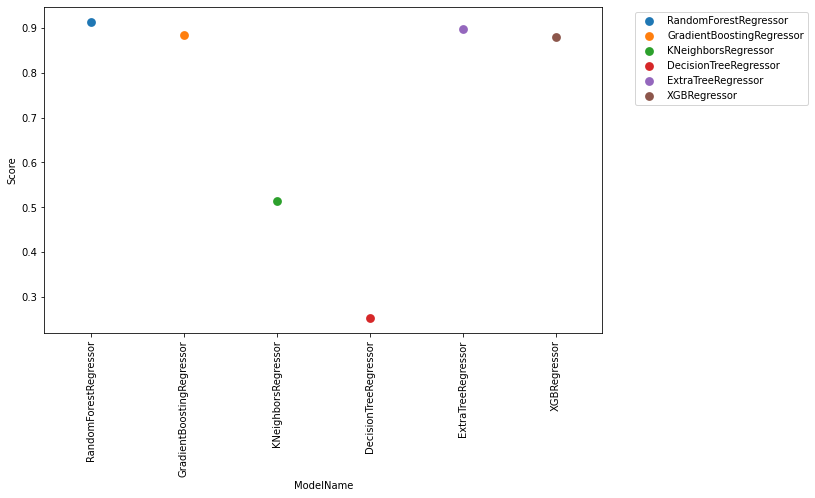

In [202]:
plt.figure(figsize=(10, 6))
sns.pointplot(data=ModelScore, x='ModelName', y='Score', hue='ModelName')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

### We tried multiple models but the best model was with lowest RMSE "XGB Regressor".


# Save Model for future use

In [ ]:
# save the model to disk
filename = 'finalized_models.sav'
pickle.dump(ModelScore, open(filename, 'wb'))



In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# Since xxx model has the best score so we will use it for prediction and csv output generation 

In [ ]:
loaded_model['Model' == 'XGBRegressor'].predict(x_test)

In [61]:
predications = np.round(predications,1)

In [62]:
pd.DataFrame(predications).to_csv("output.csv",index=False,header=False)

In [ ]:
error = math.sqrt(mean_squared_error(df_y_train, predications))
r2Score = metrics.r2_score(df_y_train,predications)
error_xgb,r2Score

In [29]:
df_X_train.shape,df_y_train.shape

((21776590, 23), (21776590, 1))

In [22]:
model = RandomForestRegressor(n_estimators = 1000, warm_start= True)

In [23]:
model.fit(df_X_train, df_y_train)

NameError: name 'df_y_train' is not defined

In [ ]:
# save the model to disk
filename = 'rfr_clean_2022_03_29_3_37.sav'
pickle.dump(ModelScore, open(filename, 'wb'))

